In [1]:
import os, struct
import numpy as np
import pandas as pd
%matplotlib notebook

# Define functions

In [2]:
def read_raw(file_to_load):

    FH  = open(file_to_load, 'rb')
    statinfo = os.stat(file_to_load)

    (dim,) = struct.unpack('<B', FH.read(1))
    raw = np.reshape(struct.unpack('<'+str(statinfo.st_size-1)+'B',FH.read(statinfo.st_size-1)), (-1,3))
    FH.close()

    return raw


# convert raw numpy file to raw binary
def npy2bin(npy_file,bin_file,smoothing=0):

    # load original sensor data from numpy file (converted from HHG)
    dta = np.load(npy_file,mmap_mode='r')

    # extract RLE encoded acceleration data
    rle = np.array((dta['d'],dta['x'],dta['y'],dta['z'])).transpose()

    # convert from RLE to pure RAW data
    raw = np.vstack([ v[0]*[v[1:]] for v in rle ])

    # optional smoothing
    if smoothing:
        raw = np.array( np.round( 
                [smooth(x,smoothing) for x in raw.transpose()]), 
                np.uint8 ).transpose()

    # write the RAW data to binary file (for mswab)
    f = open(bin_file,"wb")     # open file handler
    f.write("%c"%(np.byte(3)))  # write number of axes
    raw.tofile(f)               # store data to file
    f.close                     # close file handler

# read segments from file
def read_segments(file_to_load):

    FH  = open(file_to_load, 'rb')

    # read number of axes and number of segments per axis
    (dim,) = struct.unpack("<B", FH.read(1))
    rng = np.array(struct.unpack(str(dim)+'I',FH.read(dim*4)))

    # read segments, reshape to 2D array, append to segments list
    segments = [np.reshape(
                        struct.unpack('<'+str(2*rng[i])+'B',FH.read(2*rng[i])),
                        (rng[i],2) ) for i in range(0,dim) ]
    FH.close()

    # cumlative sum: delta values -> real inidices
    for i in range(0,dim):
        segments[i][:,0] = np.cumsum(segments[i][:,0])
    return segments

# run mSWAB approximation
def run_approx(algo,mt,bf,binfile,segsfile):
    rtrn = os.system('./bin/main_segs %ssegs %d %d %s %s '%(algo,mt,bf,binfile,segsfile))
    if rtrn:
        raise 'Error [%d] during approximation!'%(rtrn)

# Run appriximation algorithm

In [3]:
algo = 'mSWABsegs'  # SWABsegs
mt = 20             # merging threshold
bf = 80             # buffer size initial value

binfile = 'data/hapkido.bin'
segsfile = 'data/hapkido.segs'

In [4]:
run_approx(algo,mt,bf,binfile,segsfile)

# Load raw data and segments, convert to pandas and plot

In [5]:
raw = read_raw(binfile)
segs = read_segments(segsfile)

In [6]:
pd_raw = pd.DataFrame(data=raw, columns=['x','y','z'])

<IPython.core.display.Javascript object>


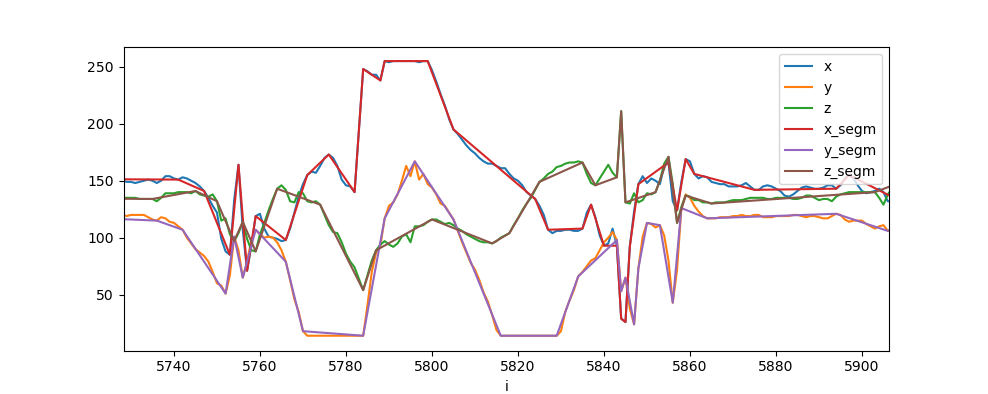

In [7]:
ax = pd_raw.plot()

In [8]:
pd_segments = []
for i,segments in enumerate(segs):
    lbl = pd_raw.columns[i] + '_segm'
    pd.DataFrame(data=segments, columns=['i',lbl]).set_index('i').plot(ax=ax)   